In [1]:
from UZ_utils import *
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
from a5_utils import *

%matplotlib widget
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [2]:
f = 0.0025
T = 0.12

pz = np.linspace(0.1, 10, num=100)

d = (f / pz) * T
#make 1d plot

#plt.plot(d)
#save plot
#plt.savefig('plot1.png')

#plt.show()

# specific case 
f=2.5mm
T=120mm
x1=550px
x2=300px
pixinmm=0.0074 mm

transform pix to mm

x1 = 550 * 0.0074 = 4.07 mm
x2 = 300 * 0.0074 = 2.22 mm

disparity = x1 - x2 = 4.07 - 2.22 = 1.85 mm

pz = f * T / disparity = 2.5 * 120 / 1.85 = 162.16 mm







#drugi primer 

x2 = 540 * 0.0074 = 3,996 mm

disparity = x1 - x2 = 3,996 - 2,22 = 1,776 mm

pz = f * T / disparity = 2.5 * 120 / 1.776 = 168.97 mm





In [3]:
def read_points(file):

    data = file.read()
    data = data.split()
    data = np.array(data)
    data = np.copy(data.astype(np.float64))
    data = data.reshape((10, 4))
    pointsItemp = data[:, :2]
    pointsJtemp = data[:, -2:]
    pointsI = []
    pointsJ = []
    for i in range(0, 10):
        pointsI.append((pointsItemp[i][0], pointsItemp[i][1]))
        pointsJ.append((pointsJtemp[i][0], pointsJtemp[i][1]))
    matches = []
    for i in range(0, 10):
        matches.append((i, i))
    return (pointsI, pointsJ, matches)

# exercize 2

In [4]:
def fundamental_matrix(points1, points2, matches, draw=True):

    #Create A matrix
    A = np.zeros((len(matches), 9))

    #normalize points
    transformed1, T1 = normalize_points(np.array(points1))
    transformed2, T2 = normalize_points(np.array(points2))

    X1 = []
    X2 = []
    for i in matches:
        X1.append(transformed1[i[0]])
        X2.append(transformed2[i[1]])
    
    #u and v are now normalized points in homogeneous coordinates

    #fill A matrix
    for i in range(0, len(matches)):
        u1, v1, w1 = X1[i]
        u2, v2, w2 = X2[i]
        A[i] = [u1*u2, u1*v2, u1, v1*u2, v1*v2, v1, u2, v2, 1]


    #SVD
   
    U, S, V = np.linalg.svd(A)

    # U is the matrix of eigenvectors of A^T*A
    # V is the matrix of eigenvectors of A*A^T
    # S is the vector of eigenvalues of A^T*A

    #this decomposes to USV^T = A^T*A

    #GET V
    V = V.T
    #get last column of V
    f = V[:, -1]
    #reshape to 3x3
    F = f.reshape((3, 3))
    #print("------------------")
    #print(F)

    #Decompose F
    U, S, V = np.linalg.svd(F)
    D = np.diag(S)
    D[-1] = 0

    #reconstruct F
    Ff = np.dot(U, D)
    Ff = np.dot(Ff, V)
    
    #denormalize F
    Ff = np.dot(T2.T, Ff.T)
    Ff = np.dot(Ff, T1)

    #print(Ff)

    #get epipoles
    U, S, V = np.linalg.svd(Ff)
    V = V.T
    e1 = V[:, 2] / V[2, 2]
    e2 = U[:, 2] / U[2, 2]

    #print(e1, e2)

    if draw:
        I = cv2.imread('data/epipolar/house1.jpg')
        I = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
        J = cv2.imread('data/epipolar/house2.jpg')
        J = cv2.cvtColor(J, cv2.COLOR_RGB2GRAY)

        plt.subplot(1, 2, 1)
        plt.imshow(I, cmap="gray")

        #draw points
        for i in range(0, len(points1)):

            plt.plot(points1[i][0], points1[i][1], 'ro',markersize=4)



        h, w = I.shape

        for i in range(0, len(points2)):
            x = (points2[i][0], points2[i][1], 1)
            line = np.dot(Ff.T, x)
            draw_epiline(line, h, w)

        plt.subplot(1, 2, 2)
        plt.imshow(J, cmap="gray")

        h, w = J.shape


        #draw points
        for i in range(0, len(points2)):
            plt.plot(points2[i][0], points2[i][1], 'ro',markersize=4)

            

        for i in range(0, len(points1)):
            x = (points1[i][0], points1[i][1], 1)
            line = np.dot(Ff, x)
            draw_epiline(line, h, w)

        plt.show()

    return Ff

    


   

    



    





        




    




I=Fx 

I = a ,b ,c 
where a,b,c arethe parameters of the line

ax + by + c = 0

y = -a/b * x - c/b

In [5]:
def reprojection_error(F, point1, point2):

    line1 = np.dot(F, point1)
    line2 = np.dot(F.T, point2)

    #print(line1, line2)

    #calculate distance from point to line
    average = 0

    #get line equation
    a1, b1, c1 = line1
    a2, b2, c2 = line2
    #line equation is ax + by + c = 0
    #where a and b are the normal vector
    

    #calculate distance
    d1 = abs(a1*point2[0] + b1*point2[1] + c1) / np.sqrt(a1**2 + b1**2)
    d2 = abs(a2*point1[0] + b2*point1[1] + c2) / np.sqrt(a2**2 + b2**2)

    average = (d1 + d2) / 2

    return average


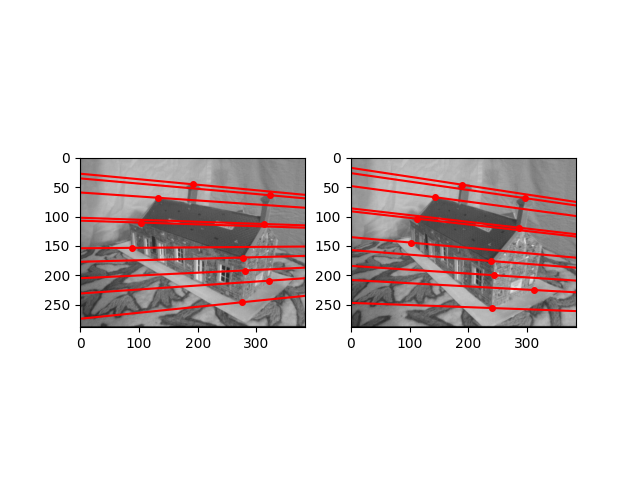

average error of point 1 and 2:  0.14674365570466286
average error:  0.3309133698053858


In [6]:
file = open('data/epipolar/house_points.txt', 'r')

(points1, points2, matches) = read_points(file)
file.close()

F = fundamental_matrix(points1, points2, matches)

point1 = (85, 233, 1)
point2 = (67, 219, 1)
average = reprojection_error(F, point1, point2)
print("average error of point 1 and 2: ", average)

#turn points into homogeneous coordinates
points1 = np.array(points1)
points2 = np.array(points2)

points1 = np.hstack((points1, np.ones((points1.shape[0], 1))))
points2 = np.hstack((points2, np.ones((points2.shape[0], 1))))

#calculate average error
average = 0
for i in range(0, len(matches)):
    average += reprojection_error(F, points1[i], points2[i])

average = average / len(matches)
print("average error: ", average)





# Exercise 3

In [7]:
def triangulation(correspondences, P1, P2):

    #coresponances is text px1 py1 p2x p2y
    #P1 and P2 are projection matrices
    correspondences = correspondences.split("\n")
    correspondences = correspondences[:-1]

    points1 = []
    points2 = []
    matches = []
    p1x_ = []
    p1y_ = []
    p2x_ = []
    p2y_ = []

    for i in range(0, len(correspondences)):
        #print(i)
        p1x, p1y, p2x, p2y = correspondences[i].split(" ")
        
        #print (p1x, p1y, p2x, p2y,0)
        #float 
        p1x = float(p1x)
        p1y = float(p1y)
        p2x = float(p2x)
        p2y = float(p2y)
        p1x_.append(p1x)
        p1y_.append(p1y)
        p2x_.append(p2x)
        p2y_.append(p2y)
        points1.append((p1x, p1y))
        points2.append((p2x, p2y))
        matches.append((i,i))

    #print( matches)

    #get fundamental matrix
    F = fundamental_matrix(points1, points2, matches, draw=False)

    results=[]
    for i in range(0, len(points1)):
        x1x = np.zeros((3, 3))
        x1x[0, 1] = -1
        x1x[0, 2] = points1[i][1]
        x1x[1, 0] = 1
        x1x[1, 2] = -points1[i][0]
        x1x[2, 0] = -points1[i][1]
        x1x[2, 1] = points1[i][0]

        x2x = np.zeros((3, 3))
        x2x[0, 1] = -1
        x2x[0, 2] = points2[i][1]
        x2x[1, 0] = 1
        x2x[1, 2] = -points2[i][0]
        x2x[2, 0] = -points2[i][1]
        x2x[2, 1] = points2[i][0]

        # If we combine in a matrix A the
        #  first two lines of the product [x1×]P1
        #  and first two lines of the product [x2×]P2,
        #  we can compute the mean quadratic estimate of
        #  X by solving a linear equation system AX = 0.
        A = np.zeros((4, 4))
        A[0:2, :] = np.dot(x1x, P1)[0:2, :]
        A[2:4, :] = np.dot(x2x, P2)[0:2, :]

        #solve for X
        U, S, V = np.linalg.svd(A)
        V=V.T
        X = V[:, 3] / V[3, 3]

        results.append(X[:3])


    I = cv2.imread('data/epipolar/house1.jpg')
    I = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
    J = cv2.imread('data/epipolar/house2.jpg')
    J = cv2.cvtColor(J, cv2.COLOR_RGB2GRAY)

    plt.plot(p1x_, p1y_, 'r.')
    plt.imshow(I, cmap="gray")
    plt.show()

    plt.plot(p2x_, p2y_, 'r.')
    plt.imshow(J, cmap="gray")
    plt.show()



    return results




        


    

    

[[ 1.6108033e+01  1.3704159e+01 -6.7351564e+01 -1.8838024e+02]
 [ 8.2886212e-01 -6.1257005e+01 -2.7985739e+01 -7.4190016e+00]
 [ 1.6739784e-01 -4.5720139e-02 -8.4811075e-02  5.6548906e-01]]


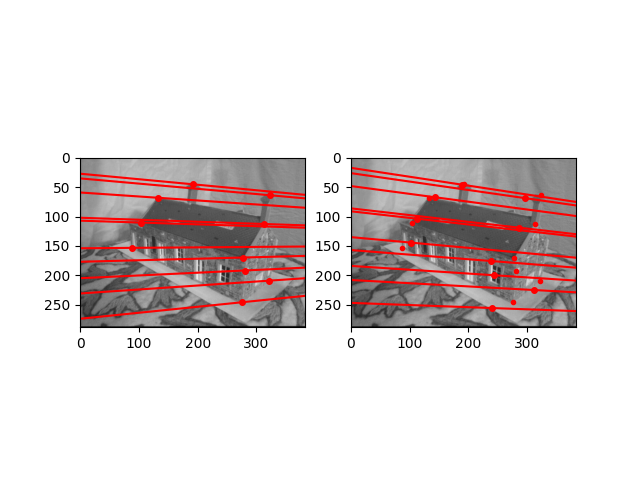

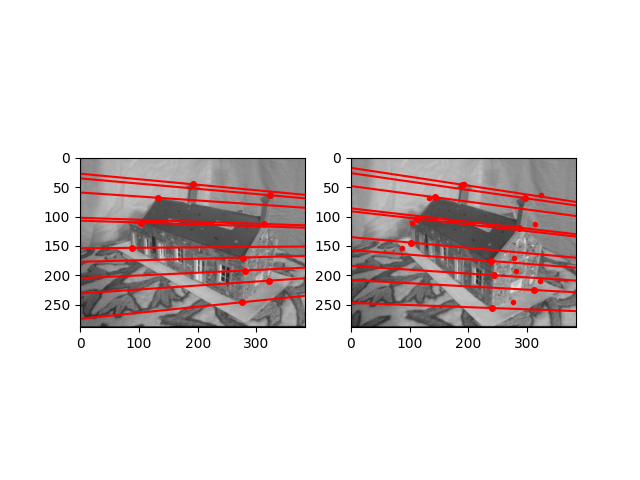

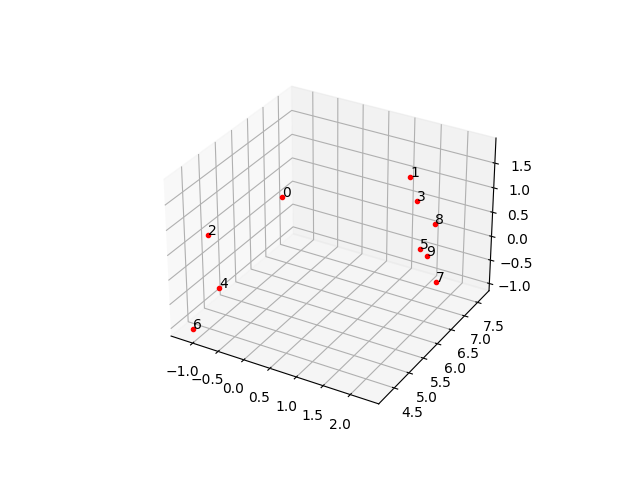

In [8]:
file = open('data/epipolar/house_points.txt')
correspondences = file.read()
file.close()

file = open('data/epipolar/house1_camera.txt')
camera1 = file.read().strip().split("\n")
C1 = np.zeros((3, 4))

for i in range(0, 3):
    #print(camera1[i].strip())
    #split by space (can have multiple spaces)
    h = camera1[i].split(" ")
    #remove empty strings
    h = list(filter(None, h))
    C1[i] = h

file.close()

file = open('data/epipolar/house2_camera.txt')
camera2 = file.read().strip().split("\n")
C2 = np.zeros((3, 4))

for i in range(0, 3):
    #split by space (can have multiple spaces)
    h= camera2[i].split(" ")
    #remove empty strings
    h = list(filter(None, h))
    C2[i] = h

file.close()

print(C1)



# # creating a figure
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # setting the axes properties
# ax.set_xlim3d([-1.0, 1.0])
# ax.set_xlabel('X')

# ax.set_ylim3d([-1.0, 1.0])
# ax.set_ylabel('Y')

# ax.set_zlim3d([-1.0, 1.0])
# ax.set_zlabel('Z')

# ax.set_title('3D Test')

# # defining all 3 axes
# x = [0, 1, 0, 0]
# y = [0, 0, 1, 0]
# z = [0, 0, 0, 1]

# # plotting
# ax.plot(x, y, z, color='r')

# plt.show()


results=triangulation(correspondences, C1, C2)

T = np.array([[-1, 0, 0], [0, 0, 1], [0, -1, 0]])
results = np.dot(results, T)




fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, pt in enumerate(results):
    plt.plot([pt[0]], [pt[1]], [pt[2]], 'r.')
    ax.text(pt[0], pt[1], pt[2], str(i))

plt.show()